# MNIST with KMeans
## Part 1
### Getting the Data

Clustering algorithms are useful ways to categorize data that follows some pattern. For this project we will investigate the k-means algorithm. K-means is an unsupervised machine learning algorithm, meaning you feed it data and it will automatically categorize it. 
<br>We can begin by importing some useful libraries. 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

We will perform our experiments on the MNIST database. This includes 60,000 handwritten digits from 0 to 9. Images are represented as 784 dimensional vectors, and labels is comprised of the corresponding digit represented by said vector. 

In [27]:
from pathlib import Path
import requests
import numpy as np
import gzip

mnist_url = "http://yann.lecun.com/exdb/mnist/"
img_file = "train-images-idx3-ubyte.gz"
labels_file = "train-labels-idx1-ubyte.gz"

for fname in [img_file, labels_file]:
    if Path(fname).is_file() :
        print(f"Found: {fname}")
        continue
    print(f"Downloading: {fname}")
    r = requests.get(mnist_url + fname)
    with open(fname, 'wb') as foo:
        foo.write(r.content)

with gzip.open(img_file, 'rb') as foo:
    f = foo.read()
images = np.array([b for b in f[16:]]).reshape(-1, 28*28)

with gzip.open(labels_file, 'rb') as foo:
    f = foo.read()
labels = np.array([b for b in f[8:]])

Found: train-images-idx3-ubyte.gz
Found: train-labels-idx1-ubyte.gz


To illustrate, we can simply grab one of the images (images[50]), and reshape it to 2-dimensions so that it looks like a flate image. 
<br>a single image inside of the 'images' variable looks like this:

In [28]:
img = images[90].reshape(28, 28)
with np.printoptions(linewidth=5*28):
    print(img)

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  25 214 225  90   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   7 145 212 253 253  60   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 106 253 253 246 188  23   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0  45 164 254 253 223 108   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0  24 236 253 252 124  28   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0 100 217 253 218 116   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0 158 175 225 253  92   0   0   0   0   

And its label is of course 6.

In [29]:
labels[90]

6

### Fitting KMeans

Using sklearn's KMeans function, we specify that we want 10 clusters (for the 10 digits). We then feed the images into the algorithm. We set the random state to 0 so that the clusters are the same every time.

In [36]:
from sklearn.cluster import KMeans

images = images
labels = labels

km  = KMeans(n_clusters=10, random_state = 0)
km.fit(images)

KMeans(n_clusters=10, random_state=0)

KMeans splits data into clusers, and each cluster has a center, or average. Do these cluster centers resemble digits?

We can print each cluster center to find out:

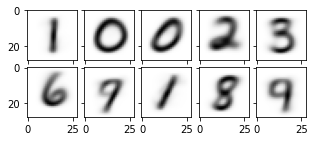

In [47]:
from mpl_toolkits.axes_grid1 import ImageGrid

centers = km.cluster_centers_.reshape(10, 28, 28)
fig = plt.figure(figsize=(5., 5.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 5),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

for ax, im in zip(grid, [centers[0], centers[1], centers[2], centers[3], centers[4], centers[5], centers[6], centers[7], centers[8], centers[9]]):
    # Iterating over the grid returns the Axes.
    ax.imshow(im, cmap='Greys')

plt.show()

And they do! Each cluster center resembles a digit, though not all digits represented in images are represented. It features a clear 2, 3, 6, and 8, but has three repeated digits. 
<br> KMeans has accomplished this with no information about what a digit actually is.
<br>
This print is adapted from matplotlib's suggestion for image grids: https://matplotlib.org/3.1.1/gallery/axes_grid1/simple_axesgrid.html

But how accurate are these classifications? 
<br>To answer this, we can create a confusion matrix. Each row corresponds to the actual categorization of a digit, and each column corresponds to the closest cluster center's index.

### Kmean's Accuracy

In [38]:
km_labels = km.labels_

acc = np.zeros((10, 10), dtype=int)

for i in range(len(labels)):
    k_lab = km_labels[i]
    r_lab = labels[i]
    acc[r_lab, k_lab] = acc[r_lab, k_lab] + 1

We can use the seaborn library to make a heatmap representing the confusion matrix. Here are some key notes.
-  Images whose true label was 0 were split between the two clusters resembling zeros the most (the first and second ones)
-  Images whose true label was 1 were split between the two clusters resembling zeros the most (the first and eighth ones)
-  Five, which had no clear representation in the cluser centroids, was most often confused for 3, 7, and 8.

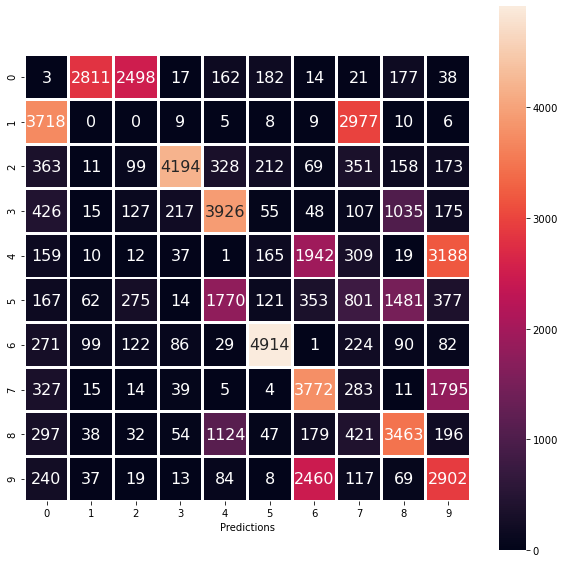

In [39]:
plt.figure(figsize=(10, 10))

sns.heatmap(
    acc,
    annot=True,
    annot_kws={"fontsize": 16},
    cbar=True,
    linewidth=2,
    square=True,
    fmt="d"
)
plt.xlabel("Predictions")
plt.show()

Though not perfect, it is still impressive that the algorithm can be this accurate without having any information about the labels!

## Part 2

### Introducing K-Nearest Neighbors

Another common machine learning algorithm is the K-Nearest Neighbors algorithm (K-NN). For example, on this data set it would rank the images 'closest' to some input image, and then classifying based on the most labels of the closest images.
<br>Though accurate, the K-NN algorithm is extremely slow on high numbers of images. For example, if we were to apply the KMeans algorithm to this data set, it would have to run 784 operations per every image! 
<br> So we will attempt to make this faster using <b>KMeans</b> to reduce its dimensionality.

### Applying KMeans

We can start this process by first permuting the data set, preventing any patterns in the data set.

In [40]:
from sklearn.neighbors import KNeighborsClassifier

In [11]:
rng = np.random.default_rng(2)
reorder = rng.permutation(len(images))
reorder

array([58490, 29928, 51871, ..., 29028,   840, 22721])

In [12]:
images = images[reorder]
labels = labels[reorder]

Since K-Nearest Neighbors is a <b>supervised</b> machine learning algorithm, we need to split the images into a training set and a testing set. 
<br>We then fit KMeans to the training set, labeled 't_images'.

In [13]:
test_num = 1000
t_images = images[:test_num]
t_labels = labels[:test_num]

n_images = images[test_num:2000]
n_labels = labels[test_num:2000]

km  = KMeans(n_clusters=10)
km.fit(t_images)

KMeans(n_clusters=10)

KMeans has a built in function called 'reduce'. This stores every image as a <b>distance</b> from each of the 10 cluster centers.
<br> In doing this we reduce the dimensionality of the data from 748 to just 10! So when classifying each image we have to do far fewer operations.

In [41]:
reduced = km.transform(n_images)

t_reduced = km.transform(t_images)
t_reduced

array([[2331.51010554, 2587.60508345, 2369.03518535, ..., 2383.3222658 ,
        2264.9284469 , 2116.45442894],
       [2225.61301842, 2271.52198619, 2581.66985912, ..., 2273.63025136,
        2469.07487396, 2057.8879485 ],
       [1879.13265075, 2071.31316808, 1969.76568581, ..., 1981.61525573,
        1902.42588065, 2088.69570753],
       ...,
       [1700.64563669, 2362.99284756, 2282.83676843, ..., 1389.17927597,
        1789.88003021, 1867.44512477],
       [2356.20933205, 2489.42550835, 2173.04656048, ..., 2091.1591474 ,
        2100.08503136, 2331.51577106],
       [2514.12469064, 1629.69081994, 1522.27659378, ..., 2538.22288231,
        2060.12075644, 2209.58363183]])

We will compare the dimensionally reduced data with the normal data with two metrics, speed and accuracy.

First, lets look at the normal data. We fit the knn function on the training set, and then use 'KNeighborsClassifier.score()' to check the percentage of images the algorithm classifies properly.

In [43]:
%%timeit

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(t_images, t_labels)

knn.score(n_images, n_labels)

1.42 s ± 26.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [44]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(t_images, t_labels)

knn.score(n_images, n_labels)

0.865

The k-Nearest Neighbors algorithm takes about 2 seconds to label all 1000 images in the testing data, and labels them with an impressive 87% accuracy.

Now, lets see how much faster the reduced set is.

In [45]:
%%timeit

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(t_reduced, t_labels)

knn.score(reduced, n_labels)

30.6 ms ± 1.33 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [46]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(t_reduced, t_labels)

knn.score(reduced, n_labels)

0.729

The reduced set takes around 30 <b>microseconds</b> to classify the 1000 images in the testing data, but it does so with 73% accuracy, notably lower than the unreduced data.

It is pretty amazing that some creative use of KMeans can help other ML algorithms. And as we saw in part 1, it is also useful in its own right.

### Determine optimal no. of clusters with the Elbow Method 

So far, we have used 10 clusters to represent the ten possible labels. But is that the most efficiant way? What if a different number of clusters works better?

We can achieve this by solving for inertia. A large inertia value means the data is far apart from the cluster centeres. A small inertia means the clusters are tighter.

In [49]:
km.inertia_

152992554889.11963

We will check cluster numbers from 2 to 12 by creating a list of each inertia value.

In [53]:
inertia_list = []
for i in range(2, 13): 
    km = KMeans(n_clusters=i)
    km.fit(t_images)
    inertia_list.append(km.inertia_)

In [54]:
inertia_list

[3200974781.368697,
 3041302176.489587,
 2916367989.217548,
 2815135394.074061,
 2730482115.131169,
 2663928808.532296,
 2601016922.6657796,
 2554514932.4292808,
 2505375696.461155,
 2469150321.8651085,
 2431323531.953709]

As we can see, the inertia steadily decreases as the number of clusters increases. This implies that the higher the number of clusters the more accurate it will be, but there is a less significant difference in inertia as it goes along. 

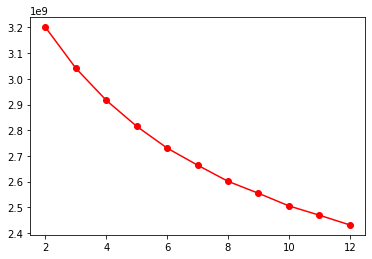

In [56]:
plt.plot(range(2,13), inertia_list, "ro-"); 

While a larger number of clusters does decrease the inertia